# 42 Draping LineStrings over Digital Elevation Model in PyVista

When displaying LineString data in combination with a Digital Elevation Model, it is desired to map LineStrings representing elements such as roads on top of the Digital Elevation Model instead of above or below. Here it is shown how to do that with GemGIS.

<img src="../images/tutorial42_cover.png">

## Set File Paths

If you downloaded the latest `GemGIS` from the Github repository, append the path so that the package can be imported successfully. In addition, the file path to the files within the `gemgis_data` folder is set. You can download the data [here](https://github.com/cgre-aachen/gemgis_data/archive/master.zip) if you have not done so.

In [1]:
import sys
sys.path.append('../../../../gemgis')
file_path ='../../../../gemgis_data/data/42_draping_linestrings_over_dem_in_pyvista/'

## Loading Mesh and Vector Data

The loaded digital elevation model will be used under Datenlizenz Deutschland – Zero – Version 2.0. It was obtained from the WCS Service https://www.wcs.nrw.de/geobasis/wcs_nw_dgm. 

In [2]:
import gemgis as gg
import pyvista as pv
import rasterio

raster = rasterio.open(file_path + 'DEM50_EPSG_4647_clipped.tif')

topo = pv.read(file_path + 'topo.vtk')
topo

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\ale93371\Anaconda3\envs\test_gempy\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


StructuredGrid (0x22c969a2d60)
  N Cells:	4923561
  N Points:	4928000
  X Bounds:	3.228e+07, 3.239e+07
  Y Bounds:	5.650e+06, 5.760e+06
  Z Bounds:	-9.627e+01, 4.243e+02
  Dimensions:	2200, 2240, 1
  N Arrays:	1

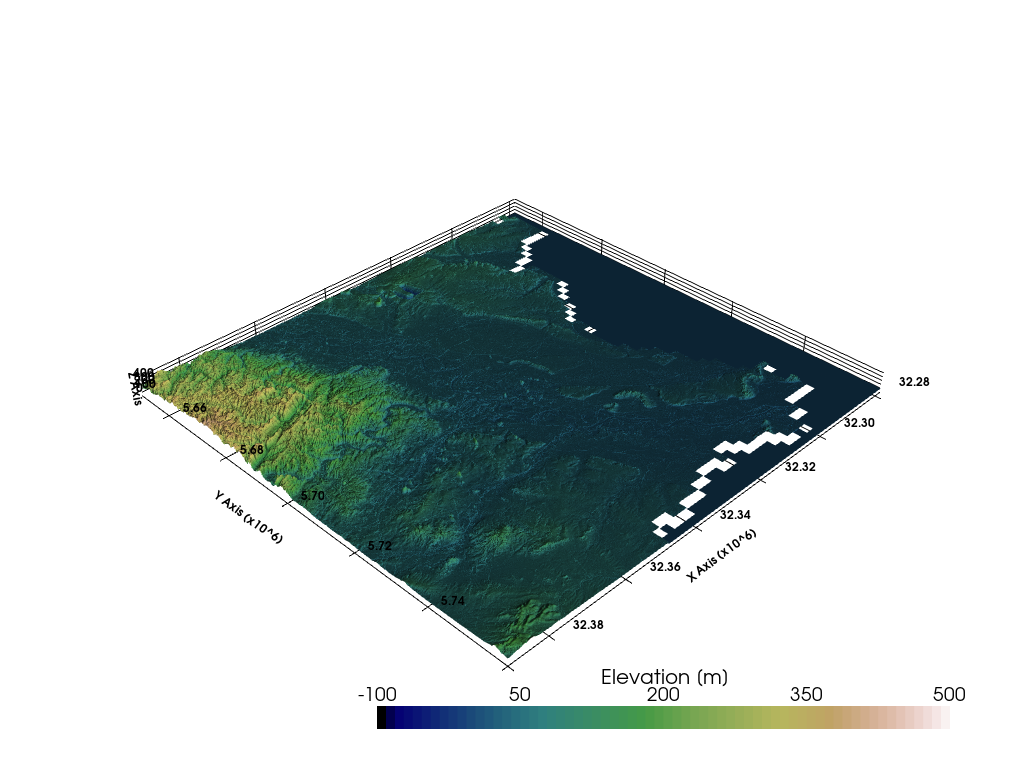

In [3]:
import pyvista as pv

sargs = dict(fmt="%.0f", color='black')

p = pv.Plotter(notebook=True)

# Adding DEM
p.add_mesh(topo, scalars='Elevation [m]', cmap='gist_earth', scalar_bar_args=sargs, clim=[-100, 500])

p.set_background('white')
p.show_grid(color='black')
p.set_scale(1,1,10)
p.show()

## Creating 3D Line of County Boundary

The boundary data was obtained from https://www.opengeodata.nrw.de/produkte/geobasis/vkg/dvg/dvg1/ and will be used under the same license as the Digital Elevation Model.

In [11]:
import geopandas as gpd

boundary = gpd.read_file(file_path + 'dvg1rbz_nw.shp')
boundary = boundary[boundary['GN'] == 'Düsseldorf']
boundary.head()

ART          GN        KN       STAND  \
0   R  Düsseldorf  05100000  2020-03-04   

                                            geometry  
0  POLYGON ((295896.673 5747849.577, 295897.626 5...

<AxesSubplot:>

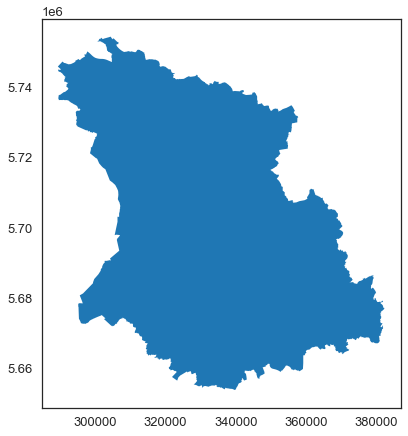

In [13]:
boundary.plot()

### Exploding Polygon to LineString

The first is to explode the polygon to a LineString using ``explode_polygons(..)``.

In [16]:
boundary_line = gg.vector.explode_polygons(gdf=boundary)
boundary_line

ART          GN        KN       STAND  \
0   R  Düsseldorf  05100000  2020-03-04   

                                            geometry  
0  LINESTRING (295896.673 5747849.577, 295897.626...

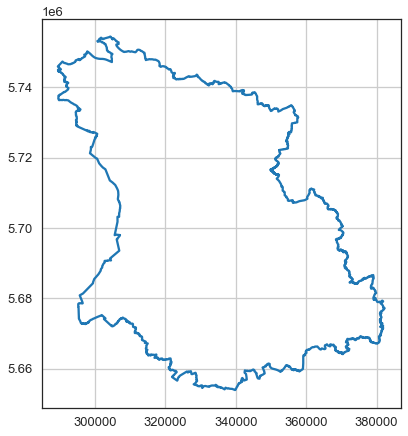

In [28]:
import matplotlib.pyplot as plt

boundary_line.plot()
plt.grid()

### Extracting vertices from line

The next step is to extract the vertices from this one line using ``extract_xyz(..)``. 

In [35]:
boundary_points = gg.vector.extract_xyz(gdf=boundary_line, dem=raster, target_crs='EPSG:4647')
boundary_points

ART          GN        KN       STAND                          geometry  \
0       R  Düsseldorf  05100000  2020-03-04  POINT (32295896.673 5747849.577)   
1       R  Düsseldorf  05100000  2020-03-04  POINT (32295897.626 5747850.839)   
2       R  Düsseldorf  05100000  2020-03-04  POINT (32295943.179 5747880.192)   
3       R  Düsseldorf  05100000  2020-03-04  POINT (32295959.070 5747891.749)   
4       R  Düsseldorf  05100000  2020-03-04  POINT (32295975.984 5747906.266)   
...    ..         ...       ...         ...                               ...   
27446   R  Düsseldorf  05100000  2020-03-04  POINT (32295802.571 5747693.901)   
27447   R  Düsseldorf  05100000  2020-03-04  POINT (32295840.751 5747767.801)   
27448   R  Düsseldorf  05100000  2020-03-04  POINT (32295857.959 5747796.720)   
27449   R  Düsseldorf  05100000  2020-03-04  POINT (32295870.009 5747814.641)   
27450   R  Düsseldorf  05100000  2020-03-04  POINT (32295896.673 5747849.577)   

                X          Y     Z  
0     32295896.67 5747849.58 11.49  
1     32295897.63 5747850.84 11.56  
2     32295943.18 5747880.19 11.44  
3     32295959.07 5747891.75 11.70  
4     32295975.98 5747906.27 11.55  
...           ...        ...   ...  
27446 32295802.57 5747693.90 11.58  
27447 32295840.75 5747767.80 11.44  
27448 32295857.96 5747796.72 11.65  
27449 32295870.01 5747814.64 11.49  
27450 32295896.67 5747849.58 11.49  

[27451 rows x 8 columns]

### Creating LineString with Z component

A LineString with a Z component can be created using ``create_linestring_from_xyz_points(..)``.

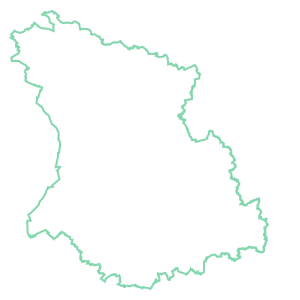

In [36]:
boundary_line_z = gg.vector.create_linestring_from_xyz_points(points=boundary_points)
boundary_line_z

### Creating GeoDataFrame from LineString 

In [37]:
gdf_boundary = gpd.GeoDataFrame(geometry=[boundary_line_z])
gdf_boundary

geometry
0  LINESTRING Z (32295896.673 5747849.577 11.490,...

### Creating 3D Lines

The last step is to create the 3D lines and return the data as PyVista PolyData.


In [38]:
boundary_pv = gg.visualization.create_lines_3d(gdf=gdf_boundary)
boundary_pv['Label'] = ['Regierungsbezirk Düsseldorf']
boundary_pv

PolyData (0x238a66bbac0)
  N Cells:	1
  N Points:	27451
  X Bounds:	3.229e+07, 3.238e+07
  Y Bounds:	5.654e+06, 5.754e+06
  Z Bounds:	-4.745e+01, 3.433e+02
  N Arrays:	1

## Creating 3D lines of Faults

The same workflow can be applied to a dataset with multiple LineStrings. In this case the faults that were mapped in the area. 

In [23]:
bbox = (32250000, 5650000, 32390000, 5760000)

In [26]:
faults = gpd.read_file(file_path + 'gg_nrw_geotekst_l.shp', bbox=bbox)
faults.head()

OBJECTID_1  OBJECTID_2                           Layer_Name  \
0       52.00          52      Störung040_Quadrather Sprung_SW   
1       99.00          99  Störung067_Peringshofer Sprung 1_NE   
2      100.00         100        Störung068_Sandberg Sprung_NE   
3      101.00         101       Störung069_Bedburger Sprung_NE   
4      102.00         102     Störung070_Bedburger Sprung 1_NE   

                          Quelle              ST_NAME  OBJECTID  Id  \
0  Erft Scholle RWE Projekt 2015    Quadrather Sprung         0   0   
1  Erft Scholle RWE Projekt 2015  Peringshofer Sprung         0   0   
2  Erft Scholle RWE Projekt 2015      Sandberg Sprung         0   0   
3  Erft Scholle RWE Projekt 2015     Bedburger Sprung         0   0   
4  Erft Scholle RWE Projekt 2015     Bedburger Sprung         0   0   

  ssymbol_QB  ST_NR  ST_ART_ID  ... DIP_3D               STOE_UEB_3  \
0       None   0.00          0  ...  62.50      regionale Bedeutung   
1       None   0.00          0  ...  62.50         lokale Bedeutung   
2       None   0.00          0  ...  62.50  überregionale Bedeutung   
3       None   0.00          0  ...  62.50         lokale Bedeutung   
4       None   0.00          0  ...  62.50         lokale Bedeutung   

   STOE_TOP_H                      STOE_BASIS  ST_ART_3D  Shape_Le_2  \
0         DGM  Tertiaer_b/Praeperm_t/Karbon_t       None     9317.89   
1         DGM  Tertiaer_b/Praeperm_t/Karbon_t       None     3304.34   
2         DGM  Tertiaer_b/Praeperm_t/Karbon_t       None     3242.54   
3         DGM  Tertiaer_b/Praeperm_t/Karbon_t       None     6404.51   
4         DGM  Tertiaer_b/Praeperm_t/Karbon_t       None     1656.99   

   Versatz_TB  Doku_Versa Shape_Le_3  \
0        0.00        None    9317.89   
1        0.00        None    3304.34   
2        0.00        None    3242.54   
3        0.00        None    6404.51   
4        0.00        None    1656.99   

                                            geometry  
0  LINESTRING (32338164.037 5644376.205, 32338092...  
1  LINESTRING (32332455.392 5650412.839, 32332407...  
2  LINESTRING (32331619.679 5651276.996, 32331513...  
3  LINESTRING (32333471.001 5648319.956, 32333423...  
4  LINESTRING (32332714.438 5649401.541, 32332618...  

[5 rows x 47 columns]

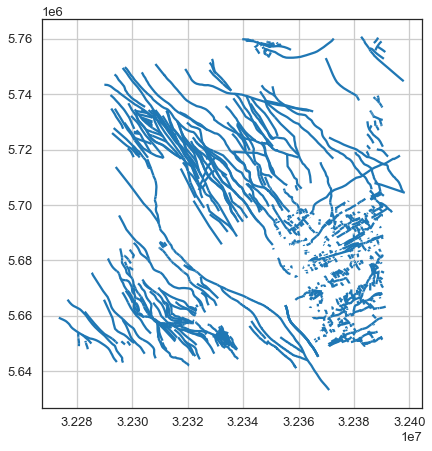

In [29]:
import matplotlib.pyplot as plt

faults.plot()
plt.grid()

### Extracting vertices from line

The vertices will be extracted from the lines again. Here, it is important to NOT reset the index of the resulting GeoDataFrame!

In [30]:
faults = faults[faults.is_valid]
faulst = faults[~faults.is_empty]
faults_xyz = gg.vector.extract_xyz(gdf=faults, dem=raster, reset_index=False)
faults_xyz.head()

OBJECTID_1  OBJECTID_2                       Layer_Name  \
0 0       52.00          52  Störung040_Quadrather Sprung_SW   
  0       52.00          52  Störung040_Quadrather Sprung_SW   
  0       52.00          52  Störung040_Quadrather Sprung_SW   
  0       52.00          52  Störung040_Quadrather Sprung_SW   
  0       52.00          52  Störung040_Quadrather Sprung_SW   

                            Quelle            ST_NAME  OBJECTID  Id  \
0 0  Erft Scholle RWE Projekt 2015  Quadrather Sprung         0   0   
  0  Erft Scholle RWE Projekt 2015  Quadrather Sprung         0   0   
  0  Erft Scholle RWE Projekt 2015  Quadrather Sprung         0   0   
  0  Erft Scholle RWE Projekt 2015  Quadrather Sprung         0   0   
  0  Erft Scholle RWE Projekt 2015  Quadrather Sprung         0   0   

    ssymbol_QB  ST_NR  ST_ART_ID  ...                      STOE_BASIS  \
0 0       None   0.00          0  ...  Tertiaer_b/Praeperm_t/Karbon_t   
  0       None   0.00          0  ...  Tertiaer_b/Praeperm_t/Karbon_t   
  0       None   0.00          0  ...  Tertiaer_b/Praeperm_t/Karbon_t   
  0       None   0.00          0  ...  Tertiaer_b/Praeperm_t/Karbon_t   
  0       None   0.00          0  ...  Tertiaer_b/Praeperm_t/Karbon_t   

     ST_ART_3D  Shape_Le_2  Versatz_TB  Doku_Versa  Shape_Le_3  \
0 0       None     9317.89        0.00        None     9317.89   
  0       None     9317.89        0.00        None     9317.89   
  0       None     9317.89        0.00        None     9317.89   
  0       None     9317.89        0.00        None     9317.89   
  0       None     9317.89        0.00        None     9317.89   

                             geometry           X          Y       Z  
0 0  POINT (32338164.037 5644376.205) 32338164.04 5644376.20 9999.00  
  0  POINT (32338092.156 5644454.183) 32338092.16 5644454.18 9999.00  
  0  POINT (32338020.275 5644532.162) 32338020.28 5644532.16 9999.00  
  0  POINT (32337976.168 5644579.490) 32337976.17 5644579.49 9999.00  
  0  POINT (32337847.430 5644717.324) 32337847.43 5644717.32 9999.00  

[5 rows x 50 columns]

### Creating LineStrings with Z component

As before, LineStrings with Z components will be created. This time, the function ``create_linestrings_from_xyz_points(..)`` is used. 

In [31]:
faults_lines_z = gg.vector.create_linestrings_from_xyz_points(gdf=faults_xyz, groupby='OBJECTID_2', return_gdf=True)
faults_lines_z

OBJECTID_1  OBJECTID_2                           Layer_Name  \
0          52.00          52      Störung040_Quadrather Sprung_SW   
1          99.00          99  Störung067_Peringshofer Sprung 1_NE   
2         100.00         100        Störung068_Sandberg Sprung_NE   
3         101.00         101       Störung069_Bedburger Sprung_NE   
4         102.00         102     Störung070_Bedburger Sprung 1_NE   
...          ...         ...                                  ...   
1510    13323.00       13324                                 None   
1511    13324.00       13325                                 None   
1512    13325.00       13326                                 None   
1513    13331.00       13332                                 None   
1514    13333.00       13334                                 None   

                                         Quelle                  ST_NAME  \
0                 Erft Scholle RWE Projekt 2015        Quadrather Sprung   
1                 Erft Scholle RWE Projekt 2015      Peringshofer Sprung   
2                 Erft Scholle RWE Projekt 2015          Sandberg Sprung   
3                 Erft Scholle RWE Projekt 2015         Bedburger Sprung   
4                 Erft Scholle RWE Projekt 2015         Bedburger Sprung   
...                                         ...                      ...   
1510                             3DLandesmodell         Hervester Sprung   
1511                             3DLandesmodell           Tertius Sprung   
1512                             3DLandesmodell          Rhader Stoerung   
1513                                    isgk100  Bergische Überschiebung   
1514  gk25_4707_Mettmann_Preußenkarte_Schriiver                     None   

      OBJECTID  Id ssymbol_QB  ST_NR  ST_ART_ID  ... DIP_3D  \
0            0   0       None   0.00          0  ...  62.50   
1            0   0       None   0.00          0  ...  62.50   
2            0   0       None   0.00          0  ...  62.50   
3            0   0       None   0.00          0  ...  62.50   
4            0   0       None   0.00          0  ...  62.50   
...        ...  ..        ...    ...        ...  ...    ...   
1510         0   0       None   0.00          0  ...  79.00   
1511         0   0       None   0.00          0  ...  80.00   
1512         0   0       None   0.00          0  ...  83.00   
1513         0   0       None   0.00          0  ...  80.00   
1514         0   0       None   0.00          0  ...   0.00   

                   STOE_UEB_3    STOE_TOP_H                      STOE_BASIS  \
0         regionale Bedeutung           DGM  Tertiaer_b/Praeperm_t/Karbon_t   
1            lokale Bedeutung           DGM  Tertiaer_b/Praeperm_t/Karbon_t   
2     überregionale Bedeutung           DGM  Tertiaer_b/Praeperm_t/Karbon_t   
3            lokale Bedeutung           DGM  Tertiaer_b/Praeperm_t/Karbon_t   
4            lokale Bedeutung           DGM  Tertiaer_b/Praeperm_t/Karbon_t   
...                       ...           ...                             ...   
1510  überregionale Bedeutung  Oberkreide_b             Praeperm_t/Karbon_t   
1511  überregionale Bedeutung  Oberkreide_b             Praeperm_t/Karbon_t   
1512  überregionale Bedeutung  Oberkreide_b             Praeperm_t/Karbon_t   
1513         lokale Bedeutung           DGM                            None   
1514      regionale Bedeutung          None                            None   

        ST_ART_3D  Shape_Le_2  Versatz_TB  Doku_Versa Shape_Le_3  \
0            None     9317.89        0.00        None    9317.89   
1            None     3304.34        0.00        None    3304.34   
2            None     3242.54        0.00        None    3242.54   
3            None     6404.51        0.00        None    6404.51   
4            None     1656.99        0.00        None    1656.99   
...           ...         ...         ...         ...        ...   
1510         None    32201.82        0.00        None   32201.82   
1511         N

### Creating 3D Lines

The last step is to create the 3D lines and return the data as PyVista PolyData.


In [33]:
faults_pv = gg.visualization.create_lines_3d(gdf=faults_lines_z)
faults_pv

PolyData (0x238a62f84c0)
  N Cells:	1515
  N Points:	36539
  X Bounds:	3.228e+07, 3.239e+07
  Y Bounds:	5.650e+06, 5.760e+06
  Z Bounds:	-8.993e+01, 4.156e+02
  N Arrays:	0

## Plotting the data on top of the DEM

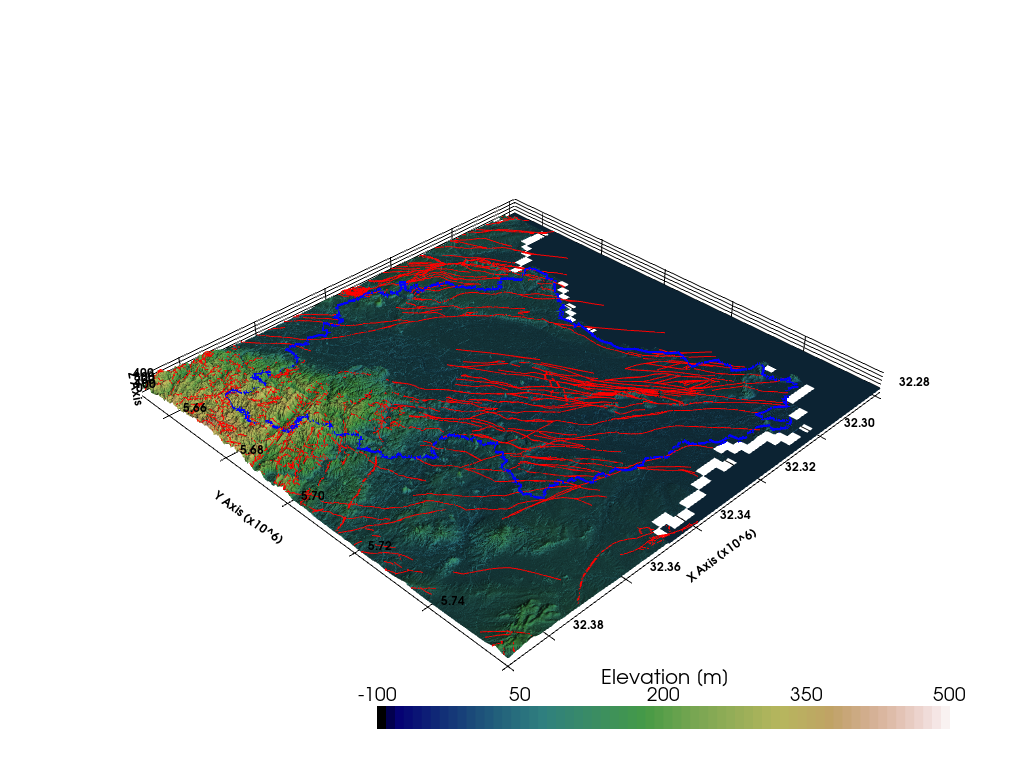

In [39]:
import pyvista as pv

sargs = dict(fmt="%.0f", color='black')

p = pv.Plotter(notebook=True)

# Adding DEM
p.add_mesh(topo, scalars='Elevation [m]', cmap='gist_earth', scalar_bar_args=sargs, clim=[-100, 500])

# Adding boundary
p.add_mesh(boundary_pv, color='blue', line_width=5)

# Adding faults
p.add_mesh(faults_pv,color='red', line_width=2)

p.set_background('white')
p.show_grid(color='black')
p.set_scale(1,1,10)
p.show()